In [1]:
# Always reload .py files
%load_ext autoreload
%autoreload 2

# Configuration
environment = 'local'


In [2]:
%% capture

# Install dependencies
if environment == 'local':
    %pip install -r ../requirements.txt
else:
    %pip install ipykernel kaggle matplotlib autopep8 pillow pandas numpy scipy urllib3 scikit-image --find-links https: // download.pytorch.org/whl/cu113/torch_stable.html torch == 1.11.0+cu113 torchaudio == 0.11.0+cu113 torchvision == 0.12.0+cu113 torch_tb_profiler tensorboard


UsageError: Cell magic `%%` not found.


In [3]:
if environment == 'colab':
    from google.colab import files
    import pathlib
    import os

    kaggle_path = '/root/.kaggle/kaggle.json'

    if not os.path.exists(kaggle_path):
        uploaded = files.upload()

        if not 'kaggle.json' in uploaded:
            raise Exception('Kaggle.json not found')

        pathlib.Path('/root/.kaggle').mkdir(exist_ok=True)
        os.rename('./kaggle.json', kaggle_path)

        !chmod 600 / root/.kaggle/kaggle.json


In [4]:
from dataset import MonetDataset, compute_stats, download_dataset
import torchvision
import torch


# Define custom paths
data_dir = os.path.join('..', 'data')

# Download the dataset
download_dataset(data_dir)

# Define preprocessing step
process = torchvision.transforms.ConvertImageDtype(torch.float)

# Load datasets
monet_dataset = MonetDataset(monet=True, data_dir=data_dir, transforms=process)
photo_dataset = MonetDataset(monet=False, data_dir=data_dir, transforms=process)

# Compute mean and std from the datasets
imgnet_mean, imgnet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
monet_mean, monet_std = compute_stats(monet_dataset)
photo_mean, photo_std = compute_stats(photo_dataset)

# Show stats
print(f'Monet Mean: {monet_mean}, Monet STD: {monet_std}')
print(f'Photo Mean: {photo_mean}, Photo STD: {photo_std}')
print(f'ImageNet Mean: {imgnet_mean}, ImageNet STD: {imgnet_std}')


Dataset already exists at ../data
Monet Mean: tensor([0.5214, 0.5244, 0.4768]), Monet STD: tensor([0.2269, 0.2203, 0.2470])
Photo Mean: tensor([0.4038, 0.4086, 0.3840]), Photo STD: tensor([0.2698, 0.2494, 0.2768])
ImageNet Mean: [0.485, 0.456, 0.406], ImageNet STD: [0.229, 0.224, 0.225]


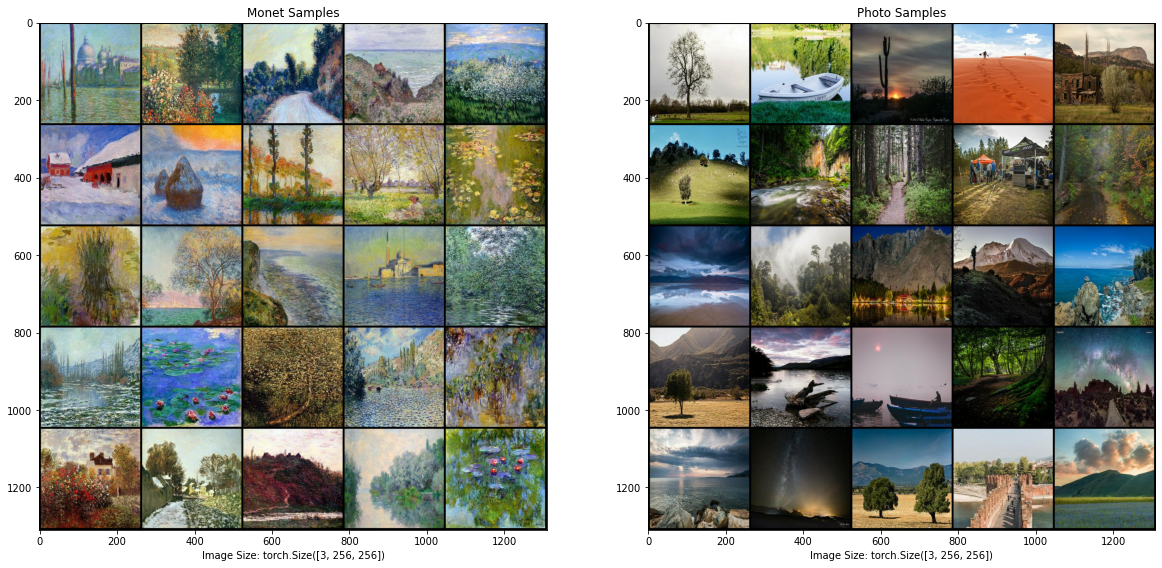

In [5]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for previewing samples
batch_size = 25
row_count = int(np.sqrt(batch_size))
monet_preview_loader = DataLoader(monet_dataset, batch_size, shuffle=True)
photo_preview_loader = DataLoader(photo_dataset, batch_size, shuffle=True)

# Get a batch of images
monet_preview_imgs = next(iter(monet_preview_loader))
photo_preview_imgs = next(iter(photo_preview_loader))

# Make a grid (image) from a couple of samples from the training dataset
monet_preview_grid = make_grid(
    monet_preview_imgs, nrow=row_count, padding=5, normalize=True)
photo_preview_grid = make_grid(
    photo_preview_imgs, nrow=row_count, padding=5, normalize=True)

# Preview the samples
fig, (monet_axis, photo_axis) = plt.subplots(1, 2, figsize=(20, 20))
monet_axis.set_title('Monet Samples')
monet_axis.set_xlabel(f'Image Size: {monet_preview_imgs[0].size()}')
monet_axis.imshow(monet_preview_grid.permute(1, 2, 0))
photo_axis.set_title('Photo Samples')
photo_axis.set_xlabel(f'Image Size: {photo_preview_imgs[0].size()}')
photo_axis.imshow(photo_preview_grid.permute(1, 2, 0))
plt.show()


![DCGAN Generator](../resources/imgs/dcgan_generator.png)


In [6]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [7]:
from model import Discriminator, Generator
from torch import nn

# Customize network initialization
noise = 128

# Define GAN networks
D = Discriminator(in_chan=3, features=64, channels=1, bias=True, device=device, \
                  activ_fun=nn.ReLU(inplace=True)) \
                 .to(device)
G = Generator(noise=noise, features=1024, channels=3, bias=False, device=device, \
              activ_fun=nn.ReLU(inplace=True))         \
             .to(device)

In [8]:
def preview_output(generator: nn.Module, noise: torch.Tensor, padding: int = 5):
    previous_mode: bool = generator.training
    generator.eval()

    with torch.no_grad():
        fake_imgs = generator(noise).cpu()
        nrows = int(torch.sqrt(torch.tensor(noise.size(0))).item())
        grid = make_grid(fake_imgs, nrow=nrows, padding=padding, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute((1, 2, 0)).numpy())
        plt.show()

    generator.train(previous_mode)

Epoch 0, D_prob_real=0.97, D_prob_fake1=0.071, D_prob_fake2=0.044, D_loss=0.12, G_loss=5.8
Epoch 1, D_prob_real=0.98, D_prob_fake1=0.067, D_prob_fake2=0.0044, D_loss=0.088, G_loss=6.5


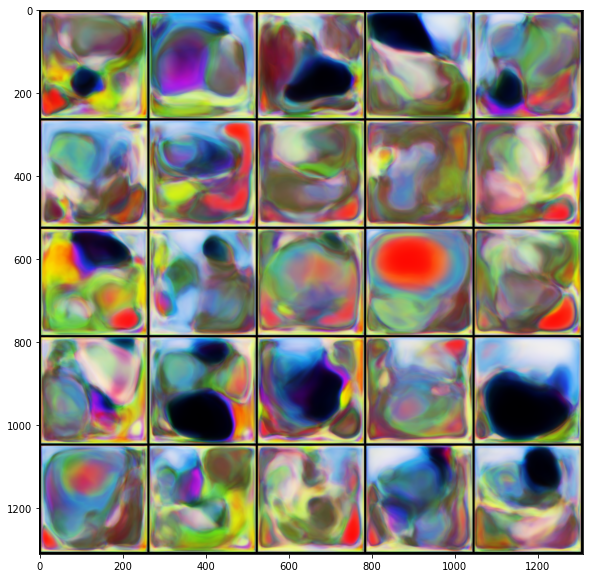

Epoch 2, D_prob_real=0.78, D_prob_fake1=0.56, D_prob_fake2=0.4, D_loss=1.2, G_loss=1.0
Epoch 3, D_prob_real=0.83, D_prob_fake1=0.3, D_prob_fake2=0.074, D_loss=0.67, G_loss=2.9
Epoch 4, D_prob_real=0.68, D_prob_fake1=0.27, D_prob_fake2=0.076, D_loss=0.81, G_loss=3.1


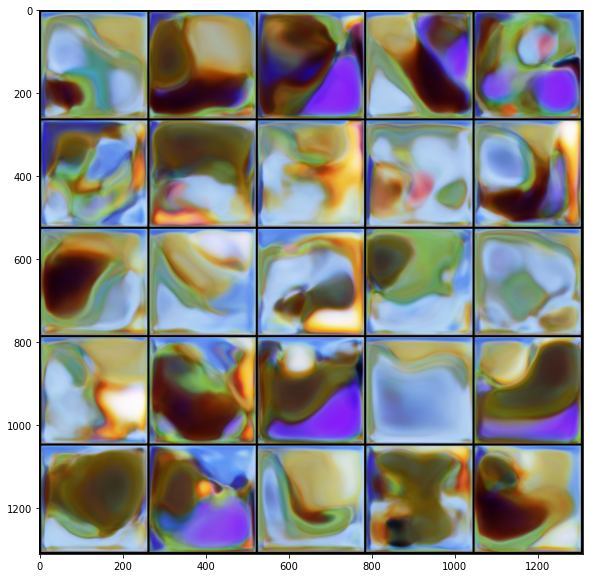

Epoch 5, D_prob_real=0.99, D_prob_fake1=0.33, D_prob_fake2=0.37, D_loss=0.49, G_loss=1.3
Epoch 6, D_prob_real=0.79, D_prob_fake1=0.24, D_prob_fake2=0.55, D_loss=0.55, G_loss=0.75
Epoch 7, D_prob_real=0.79, D_prob_fake1=0.22, D_prob_fake2=0.017, D_loss=0.53, G_loss=4.5


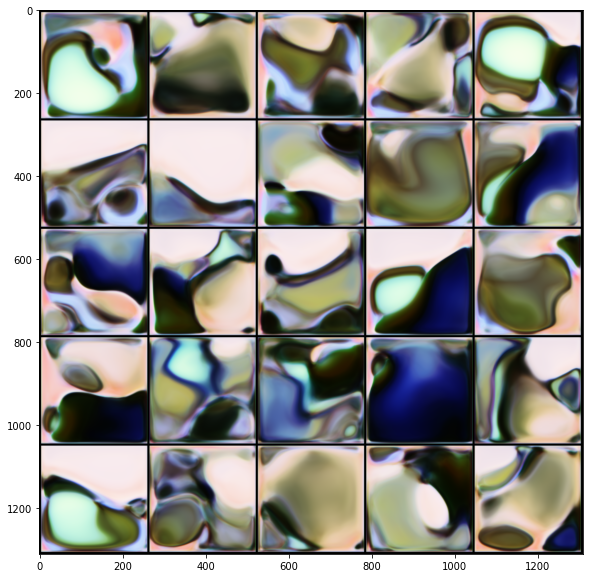

Epoch 8, D_prob_real=0.99, D_prob_fake1=0.19, D_prob_fake2=0.0031, D_loss=0.26, G_loss=6.6
Epoch 9, D_prob_real=0.99, D_prob_fake1=0.041, D_prob_fake2=0.028, D_loss=0.059, G_loss=4.8
Epoch 10, D_prob_real=0.89, D_prob_fake1=0.026, D_prob_fake2=0.13, D_loss=0.18, G_loss=2.7


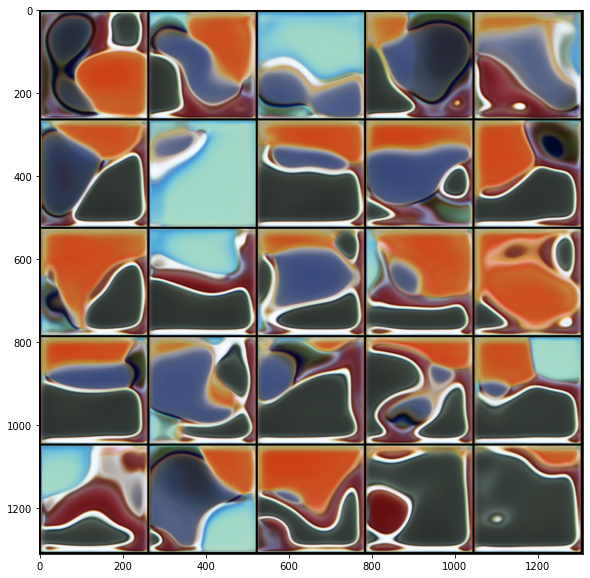

Epoch 11, D_prob_real=0.97, D_prob_fake1=0.16, D_prob_fake2=0.016, D_loss=0.22, G_loss=5.0


In [9]:
from torch.optim import Adam


# Customize training loop
epochs = 1000
d_steps = 1

# Custom batch_size
batch_size = 12

# Create optimizers for each network
optim_G = Adam(G.parameters(), lr=2e-4)
optim_D = Adam(D.parameters(), lr=2e-4)

# Specify label types
fake_label = 0.
real_label = 1.

# Define loss function
loss_fn = torch.nn.BCELoss()

# Prepare dataloader
data_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
monet_dataset.transforms = torchvision.transforms.Compose([
    torchvision.transforms.ConvertImageDtype(dtype=torch.float),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Evaluate the same noise over time
fixed_noise = torch.randn((25, noise), device=device)
sample_freq = 3

# Train the DCGAN
for epoch in range(epochs):
    for batch_idx, real_img in enumerate(data_loader):
        # Get image sizes
        N, C, H, W = real_img.size()

        # --- Train the Discriminator ---
        for step in range(d_steps):
            # Reset gradients
            optim_D.zero_grad()

            # ^^^ Classify real images ^^^
            # Send data to GPU
            real_img = real_img.to(device)

            # Compute the output of the Discriminator for real images
            out_real = D(real_img).view(-1)
            labels = torch.full((N,), real_label, device=device, dtype=torch.float)
            loss_d_real = loss_fn(out_real, labels)
            prob_d_real = out_real.detach().mean().item()

            # Accumulate gradients
            loss_d_real.backward()

            # ^^^ Classify fake images ^^^
            noise_input = torch.randn((N, noise), device=device)
            fake_img = G(noise_input)

            # Compute the output of the Discriminator for fake images
            out_fake = D(fake_img.detach()).view(-1)
            labels.fill_(fake_label)
            loss_d_fake = loss_fn(out_fake, labels)
            prob_d_fake1 = out_fake.detach().mean().item()

            # Update the model
            loss_d_fake.backward()
            optim_D.step()

            # Retain the error
            loss_d = loss_d_real + loss_d_fake

        # --- Train the Generator ---
        # Reset gradients
        optim_G.zero_grad()

        # ^^^ Classify fake images ^^^
        noise_input = torch.randn((N, noise), device=device)
        fake_img = G(noise_input)

        # Compute the output of the Discriminator for fake images
        out_fake = D(fake_img).view(-1)
        labels.fill_(real_label)
        loss_g_fake = loss_fn(out_fake, labels)
        prob_d_fake2 = out_fake.detach().mean().item()

        # Update the model
        loss_g_fake.backward()
        optim_G.step()

        # Evaluate same noise output
        if (epoch + 1) % sample_freq == 0 and batch_idx == 0:
            preview_output(G, fixed_noise)

    print(f'Epoch {epoch}, D_prob_real={prob_d_real:.2}, D_prob_fake1={prob_d_fake1:.2},',
          f'D_prob_fake2={prob_d_fake2:.2}, D_loss={loss_d:.2}, G_loss={loss_g_fake:.2}')


In [ ]:
G(fixed_noise).size()